In [1]:
from sensible_raw.loaders import loader
import numpy as np
from sklearn.preprocessing import scale
from sklearn.svm import OneClassSVM
from collections import Counter, defaultdict
import sys
from datetime import datetime as dt
import json
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from extractors.sms_extractor import Sms_extractor
from extractors.stop_locations_extractor import Stop_locations_extractor
from extractors.screen_extractor import Screen_extractor
##from facebook_friends_extractor import Facebook_friends_extractor
from extractors.bluetooth_extractor import Bluetooth_extractor
##from calllog_extractor import Calllog_extractor
##from location_extractor import Location_extractor
from extractors.big_five_extractor import Big_five_extractor

from analysis.outlier_detection import Outlier_detector_svm, Outlier_detector_kd
from analysis.location_reference import Load_location_reference
#from analysis.social_state_reference import Load_social_state_reference
from analysis.consensus_archetypes import Consensus_archetypes

In [3]:
# School periods (when there are lectures)
tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]}
# Exam periods
tc1 = {'hours': range(24), 'days': range(7), 'spans': [("17/05/14","01/06/14"), ("06/12/14", "21/12/14")]}
# Holiday periods
tc2 = {'hours': range(24), 'days': range(7), 'spans': [("01/01/14","05/01/14"), ("25/01/14","02/02/14"), ("14/04/14","20/04/14"), ("21/06/14","30/08/14"), ("22/12/14", "31/12/14")]}

In [4]:
location_reference = Load_location_reference(tc1, auxlabel="tc1_", load_reference=True)
#social_state_reference = Load_social_state_reference(tc1, auxlabel="tc1_", load_reference=False)

[location_reference] Loading datasource from local.


In [5]:
load_old_datasources = True

sms = Sms_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
stop_locations = Stop_locations_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
screen = Screen_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
##facebook_friends = Facebook_friends_extractor()
bluetooth = Bluetooth_extractor(tc0, suppress=[], auxlabel="tc0_", load_old_datasources=load_old_datasources)
##calllog = Calllog_extractor()
##location = Location_extractor()
big_five = Big_five_extractor()

[sms] Loading datasource from local.
[sms] Number of datapoints in range: 1786225
[stop_locations] Loading datasource from local.
[stop_locations] Number of datapoints in range: 450662
[screen] Loading datasource from local.
[screen] Number of datapoints in range: 20211170
[bluetooth] Loading datasource from local.
[bluetooth] Number of datapoints in range: 3312659
[big_five_extractor] Loaded data from local copy!


In [6]:
#tc0 = {'hours': range(24), 'days': range(7), 'spans': [("06/01/14","24/01/14"), ("03/02/14","16/05/14"), ("01/09/14","05/12/14"), ("02/06/14","20/06/14")]} #in school
#location_reference = Load_location_reference(tc1, auxlabel="tc1_", load_reference=False)

### Build full JSON dataset

In [7]:
with open('data_cache/users.json', 'r') as infile:
    users = [int(i) for i in json.load(infile)]

load_cached_data_sets = True

if load_cached_data_sets:
    with open('data_cache/dataset_X.json') as infile:
        dataset_X = json.load(infile)
    with open('data_cache/dataset_Y.json') as infile:
        dataset_Y = json.load(infile)
else:
    dataset_X = {}
    dataset_Y = {}

    for user in users:

        if user%10 == 0:
            print user,

        datapoint_x = {}
        datapoint_y = {}

        # Ordered by fail/execution speed
        try:
            datapoint_x.update(bluetooth.main(user))
            datapoint_x.update(stop_locations.main(user))
            datapoint_x.update(sms.main(user))
            datapoint_x.update(screen.main(user))
            #datapoint_x.update(facebook_friends.main(user))
            #datapoint_x.update(calllog.main(user))
            #datapoint_x.update(location.main(user))
            datapoint_y.update(big_five.main(user))
        except Exception as e:
            print "<"+str(e)+">",
            continue

        dataset_X[user] = datapoint_x
        dataset_Y[user] = datapoint_y
        
    # Store loaded data    
    with open('data_cache/dataset_X.json', 'w') as outfile:
        json.dump(dataset_X,outfile)
    with open('data_cache/dataset_Y.json', 'w') as outfile:
        json.dump(dataset_Y,outfile)    

X = np.array(X)
M = X.shape[1]

combs = []
for i in range(M):
    for j in range(M):
        if j <= i: continue
        combs.append((i,j))
        
M = len(combs)

cols, rows = 3, np.ceil(M/3.0)

plt.figure(figsize=(15,5*rows))
for c,(i,j) in enumerate(combs):
    plt.subplot(rows,cols,c)
    plt.scatter(X[:,i],X[:,j])
    
plt.show()

### Convert to matrix and standardize

In [8]:
features_x = sorted(dataset_X.items()[0][1].keys())
features_y = ['openness','conscientiousness','extraversion','aggreeableness','neuroticism']

#features_x = filter(lambda x: int(x[2]) in [1,3], features_x)

X = []
Y = []
for k,v in dataset_X.items():
    X.append([v[f] for f in features_x])
for k,v in dataset_Y.items():
    Y.append([v[f] for f in features_y])
    
X_scaled = scale(np.array(X))
Y = np.array(Y)
M = Consensus_archetypes().project_to_archetype_space(Y)

In [9]:
dict(zip(range(1, len(features_x)+1 ),features_x))

{1: u'tc0_bluetooth_social_entropy',
 2: u'tc0_screen_session_duration',
 3: u'tc0_screen_session_frequency',
 4: u'tc0_screen_summed_usage',
 5: u'tc0_sms_fractions_of_conversations_started',
 6: u'tc0_sms_overall_received_responsiveness',
 7: u'tc0_sms_overall_responsiveness',
 8: u'tc0_sms_selectivity_in_responsiveness',
 9: u'tc0_sms_traffic',
 10: u'tc0_stop_locations_geospacial_entropy'}

### Remove outliers

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44

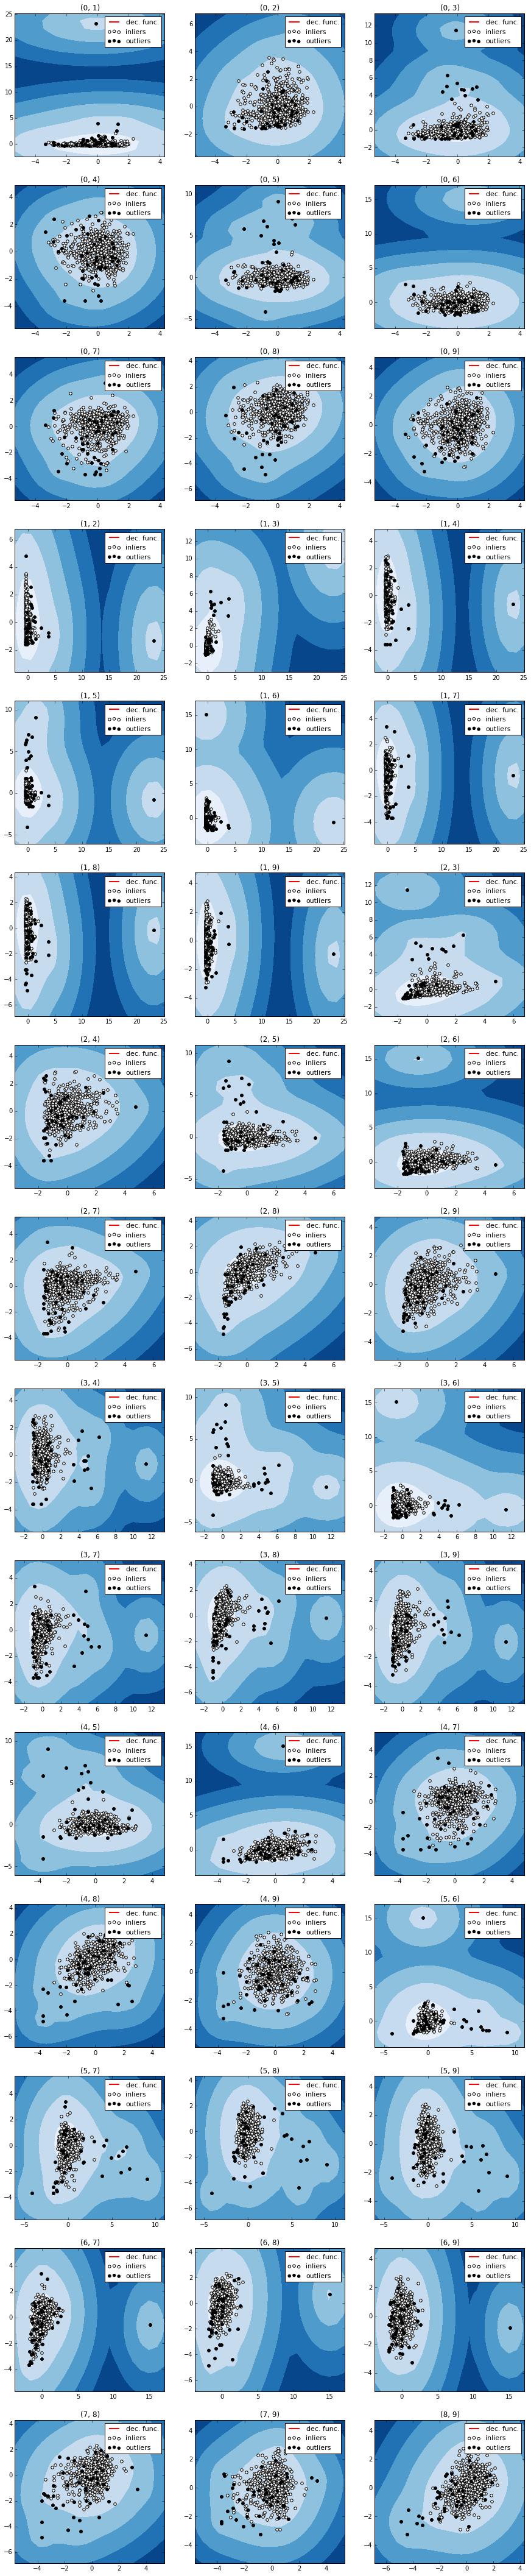

 (627, 10)
(584, 10)


In [14]:
out_svm = Outlier_detector_svm(X_scaled, hard=False, threshold=-1, visualize=True, nu=0.1, gamma=0.25)
out_kd = Outlier_detector_kd(X_scaled, visualize=True, threshold=0.07, bandwidth=0.5, kernel='exponential')
outliers = out_kd.main()

X_clean = np.delete(X_scaled,outliers,axis=0)
Y_clean = np.delete(Y,outliers,axis=0)
M_clean = np.delete(M,outliers,axis=0)

print X_scaled.shape
print X_clean.shape

np.savetxt("data/X.csv", X_clean, delimiter=",")
np.savetxt("data/Y.csv", Y_clean, delimiter=",")
np.savetxt("data/M.csv", M, delimiter=",")

In [11]:
[1,2,3,4,5][2:-1]

[3, 4]

In [12]:
component_combinations = out_kd.component_combinations
log_dens = out_kd.log_dens
X = out_kd.X[:,component_combinations[0]]

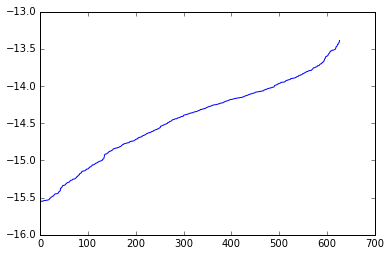

In [13]:
plt.plot(range(len(log_dens)),sorted(log_dens))

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity

np.random.seed(1000)
x = np.random.rand(10)
y = np.random.rand(10)
data = np.vstack((x, y)).T

kde = KernelDensity().fit(data)

r = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(r, r)

plot_data = np.vstack((X.ravel(), Y.ravel())).T

log_dens = kde.score_samples(plot_data)

In [29]:
log_dens.reshape(X.shape).shape

(1000, 1000)

In [33]:
np.meshgrid(range(10),range(10))

[array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])]

[(0, u'tc0_bluetooth_social_entropy'), (1, u'tc0_screen_session_duration'), (2, u'tc0_screen_session_frequency'), (3, u'tc0_screen_summed_usage'), (4, u'tc0_sms_fractions_of_conversations_started'), (5, u'tc0_sms_overall_received_responsiveness'), (6, u'tc0_sms_overall_responsiveness'), (7, u'tc0_sms_selectivity_in_responsiveness'), (8, u'tc0_sms_traffic'), (9, u'tc0_stop_locations_geospacial_entropy')]


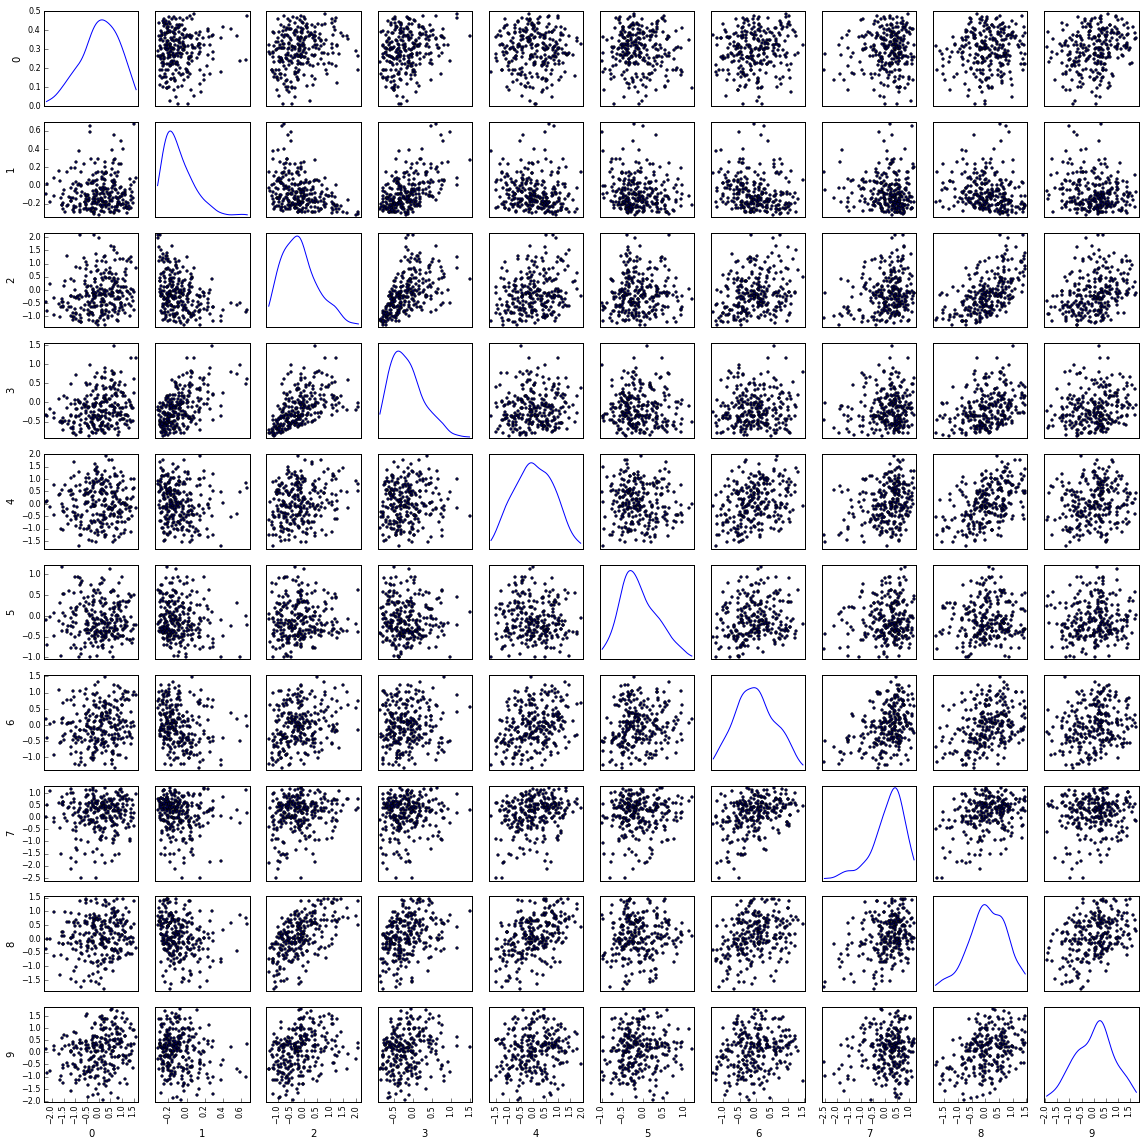

In [11]:
print zip(range(len(features_x)),features_x)
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
df = pd.DataFrame(X_clean)
pd.tools.plotting.scatter_matrix(df, alpha=1, figsize=(16,16), diagonal="kde")
plt.tight_layout()
plt.show()

In [10]:
features_x

['tc0_sms_fractions_of_conversations_started',
 'tc0_sms_overall_received_responsiveness',
 'tc0_sms_overall_responsiveness',
 'tc0_sms_selectivity_in_responsiveness',
 'tc0_sms_traffic']

In [79]:
print X_scaled.shape
print X_clean.shape

(772, 5)
(739, 5)


In [108]:
features_x

['tc0_sms_fractions_of_conversations_started',
 'tc0_sms_overall_received_responsiveness',
 'tc0_sms_overall_responsiveness',
 'tc0_sms_selectivity_in_responsiveness',
 'tc0_sms_traffic']

In [75]:
X.min()

-4.111045762890126

In [113]:
vals = [2,1,3,3,3,1,17,3,4,4,1,2,3]

In [114]:
np.mean(vals)

3.6153846153846154

In [115]:
for v in vals:
    try:
        themean = (themean+v)/2.0
    except:
        themean = v

In [132]:
component_combination = []#[(0,1),(0,2),(0,3),(0,4),(1,2),(1,3),(1,4),(2,3),(2,4),(3,4)]

In [138]:
for i in range(5):
    for j in range(5):
        if j > i:
            component_combination.append((i,j))

SyntaxError: invalid syntax (<ipython-input-138-1793cdb9a4d1>, line 1)

In [148]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [154]:
np.delete(a,[0,2],axis=0)

array([[4, 5, 6]])

In [25]:
np.array([(0,1),(0,1),(0,1),(0,1)])

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

$$y(x) = \sum_i\alpha_ik(\mathbf{x}_i,\mathbf{x})-\rho$$

In [72]:
def point_in_poly(point):
    
    poly = [(55.790357, 12.528459), 
             (55.783908, 12.525970), 
             (55.783908, 12.525970),
             (55.778790, 12.520980), 
             (55.780395, 12.512578), 
             (55.781964, 12.513425), 
             (55.782058, 12.512789), 
             (55.783010, 12.513302), 
             (55.783261, 12.512094), 
             (55.783915, 12.512722), 
             (55.783580, 12.515087), 
             (55.789931, 12.518711), 
             (55.789190, 12.522913), 
             (55.791066, 12.523995)]
    
    x, y = point

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y

    return inside

In [73]:
%timeit point_in_poly((55.781790, 12.513370))

The slowest run took 8.67 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.62 µs per loop


In [46]:
x, y = (55.781790, 12.513370)

In [90]:
"""Validate whether geographical coordinate point is at known home.
Uses known kollegiums as ground truth for home locations. Validate
fences using https://www.mapcustomizer.com/.

Algorithm from http://www.ariel.com.au/a/python-point-int-poly.html
"""

def validate(point, verbose=False):
    """Validate if point is in known home location.
    
    Parameters
    ----------
    point : (float, float)
    verbose : bool
    
    Returns
    -------
    name/bool : str/bool
        If True, return name of kollegium point is inside,
        if False, return False
    """
    def inside_polygon(poly):
        x, y = point

        n = len(poly)
        inside = False

        p1x,p1y = poly[0]
        for i in range(n+1):
            p2x,p2y = poly[i % n]
            if y > min(p1y,p2y):
                if y <= max(p1y,p2y):
                    if x <= max(p1x,p2x):
                        if p1y != p2y:
                            xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                        if p1x == p2x or x <= xints:
                            inside = not inside
            p1x,p1y = p2x,p2y

        return inside
    
    andels = [(55.780256, 12.522057), (55.780491, 12.523003),
              (55.781299, 12.523452), (55.781163, 12.524386),
              (55.780184, 12.523924), (55.779916, 12.521987)]
    kampsa = [(55.781501, 12.522751), (55.783411, 12.523814), 
              (55.783813, 12.524533), (55.783649, 12.525473),
              (55.781190, 12.524554)]
    villum = [(55.784784, 12.524647), (55.784633, 12.525645), 
              (55.784013, 12.525447), (55.784209, 12.524351)]
    willia = [(55.782516, 12.511908), (55.782425, 12.512409),
              (55.781365, 12.511568), (55.781450, 12.511026)]
    ostenf = [(55.788685, 12.531732), (55.788689, 12.533580),
              (55.787745, 12.533572), (55.787780, 12.531605)]
    viggoj = [(55.799586, 12.491374), (55.800299, 12.493603),
              (55.799319, 12.493867), (55.799090, 12.491979)]
    troero = [(55.847144, 12.526772), (55.847267, 12.530204),
              (55.846379, 12.530299), (55.846287, 12.526854)]
    nybrog = [(55.773445, 12.471626), (55.774310, 12.474543),
              (55.772307, 12.477018), (55.771529, 12.475360)]
    hjorte = [(55.740727, 12.435091), (55.740907, 12.436595),
              (55.739276, 12.437189), (55.738757, 12.435537)]
    paulbe = [(55.811511, 12.512745), (55.811238, 12.515996),
              (55.810111, 12.515977), (55.810192, 12.511739)]
    popede = [(55.764040, 12.476051), (55.764064, 12.477994),
              (55.762321, 12.477835), (55.762309, 12.476876)]
    gahage = [(55.694281, 12.586961), (55.694553, 12.587367),
              (55.694427, 12.587562), (55.694170, 12.587173)]
    lautru = [(55.730406, 12.404633), (55.730682, 12.405655),
              (55.729430, 12.406903), (55.728875, 12.404911)]
    
    
    fences = {"andels": andels, "kampsa": kampsa, "villum": villum, 
              "willia": willia, "ostenf": ostenf, "viggoj": viggoj, 
              "troero": troero, "nybrog": nybrog, "hjorte": hjorte, 
              "paulbe": paulbe, "popede": popede, "gahage": gahage, 
              "lautru": lautru}
    
    for name, poly in fences.items():
        if inside_polygon(poly): return name
        
    return False
    
    
    
    
    

In [92]:
if validate((55.780110, 12.522682), verbose=True):

lol
